# Analyzing Geographic Skill Distribution and Economic Mobility

In this project, we aim to analyze the geographic distribution of skills across U.S. metropolitan areas and investigate how the local skill composition affects economic mobility and wage growth. The following steps outline the process:

1. **Data Collection and Preprocessing**  
   Collect and clean data from various sources (O*NET, BLS, IPUMS) to understand the geographic distribution of skills, wages, and mobility.

2. **Skill Distribution Across Regions**  
   Analyze the distribution of high-skill and low-skill occupations in different metropolitan areas and quantify regional skill concentrations.

3. **Linking Skill Composition to Wage Growth and Mobility**  
   Conduct regression analysis to examine how regional skill composition influences economic mobility, including wage growth and the likelihood of upward mobility.

4. **Identification of Skill Gaps and Regional Training Potential**  
   Assess regional skill gaps by comparing local skill supply with demand and explore the potential for targeted education and training programs to address these gaps.

5. **Visualization and Reporting**  
   Visualize the geographic distribution of skill levels, wage growth, and skill gaps through heatmaps and other charts. Present the findings and implications for policy or workforce development.

We will use several datasets and methods to create visualizations and derive insights into regional economic disparities and mobility.



## Step 1: Import Required Libraries

We start by importing the necessary libraries for data manipulation, visualization, and geographic processing.



In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import us
# from shapely.geometry import Point, Polygon
# import folium
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set Matplotlib to use LaTeX-style fonts
plt.rcParams.update({
    'text.usetex': True,  # Enable LaTeX rendering
    'font.family': 'serif',  # Use serif font for LaTeX
    'font.serif': ['Times New Roman'],  # Use Times New Roman, or another LaTeX-compatible font
    'axes.labelsize': 14,  # Font size for axis labels
    'axes.titlesize': 16,  # Font size for the title
    'xtick.labelsize': 12,  # Font size for x-axis tick labels
    'ytick.labelsize': 12,  # Font size for y-axis tick labels
    'legend.fontsize': 12,  # Font size for legend
})

# Step 2: Data Collection and Preprocessing

This section loads and preprocesses the O*NET and BLS data, ensuring they are cleaned and ready for analysis. O*NET and focus on the relevant occupational codes and their automation risk scores.


## 2.1 Load BLS Occupational Employment and Wage Statistics

Next, we load the Bureau of Labor Statistics (BLS) dataset, which includes information on occupation employment and wages across different regions.

In [2]:
# Define the columns to read from the Excel files
columns = [
    "AREA",         # Area code
    "AREA_TITLE",   # Area title
    "AREA_TYPE",    # Area type (1 = US, 4 = MSA, 5 = Non-MSA, future: 2 = State, 1
    "PRIM_STATE",   # Primary state abbreviation
    "OCC_CODE",     # Occupation code
    "OCC_TITLE",    # Occupation title
    "O_GROUP",      # Occupation group (detailed < major < total)
    "TOT_EMP",      # Total employment
    "LOC_QUOTIENT", # Location quotient (relative occupation concentration)
    "A_MEAN",       # Mean annual wage
    "H_MEAN"        # Mean hourly wage
]

# Define file paths for easy configuration
file_path_msa = "./data/oesm23ma/MSA_M2023_dl.xlsx"
file_path_non_msa = "./data/oesm23ma/BOS_M2023_dl.xlsx"

# Define a function to load data and convert specific columns to numeric
def load_and_clean_data(file_path, columns, numeric_start_index):
    """Load data from an Excel file and convert specified columns to numeric."""
    try:
        # Load data using specified columns
        data = pd.read_excel(file_path, usecols=columns)
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: File not found at {file_path}")
    
    # Convert numeric columns, coercing errors to NaN
    data.iloc[:, numeric_start_index:] = data.iloc[:, numeric_start_index:].apply(pd.to_numeric, errors='coerce')
    return data

# Load and clean MSA and non-MSA data
data_msa = load_and_clean_data(file_path_msa, columns, len(columns) - 4)
data_non_msa = load_and_clean_data(file_path_non_msa, columns, len(columns) - 4)

# Display a summary of the first few rows of each dataset
print("MSA Data Sample:")
display(data_msa.head())
print("\nNon-MSA Data Sample:")
display(data_non_msa.head())


MSA Data Sample:


,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,LOC_QUOTIENT,H_MEAN,A_MEAN
0,10180,"Abilene, TX",4,TX,00-0000,All Occupations,total,72780.0,1.0,23.93,49780.0
1,10180,"Abilene, TX",4,TX,11-0000,Management Occupations,major,4930.0,0.98,48.41,100690.0
2,10180,"Abilene, TX",4,TX,11-1011,Chief Executives,detailed,40.0,0.4,115.39,240020.0
3,10180,"Abilene, TX",4,TX,11-1021,General and Operations Managers,detailed,2290.0,1.36,47.35,98480.0
4,10180,"Abilene, TX",4,TX,11-2021,Marketing Managers,detailed,120.0,0.69,55.91,116290.0



Non-MSA Data Sample:


,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,LOC_QUOTIENT,H_MEAN,A_MEAN
0,100001,Northwest Alabama nonmetropolitan area,6,AL,00-0000,All Occupations,total,67450.0,1.0,21.38,44460.0
1,100001,Northwest Alabama nonmetropolitan area,6,AL,11-0000,Management Occupations,major,2650.0,0.57,47.36,98510.0
2,100001,Northwest Alabama nonmetropolitan area,6,AL,11-1021,General and Operations Managers,detailed,860.0,0.55,54.58,113520.0
3,100001,Northwest Alabama nonmetropolitan area,6,AL,11-1031,Legislators,detailed,110.0,7.74,NaN,36040.0
4,100001,Northwest Alabama nonmetropolitan area,6,AL,11-2022,Sales Managers,detailed,80.0,0.32,65.18,135570.0


In [3]:
# Combine MSA and Non-MSA data
bls_data = pd.concat([data_msa, data_non_msa], ignore_index=True)

# Create a dictionary mapping state abbreviations to area codes
state_area_dict = bls_data[['PRIM_STATE', 'AREA']].copy()
state_area_dict['AREA'] = state_area_dict['AREA'].astype(str).str[:2]
state_area_dict = state_area_dict.drop_duplicates().set_index('PRIM_STATE')['AREA'].to_dict()

# State name dictionary
state_name_dict = us.states.mapping('abbr', 'name')

# Define area type for states
area_tye = 2

# Aggregate data by state and occupation
agg_data = bls_data.groupby(["PRIM_STATE", 'OCC_CODE', 'OCC_TITLE', 'O_GROUP']).agg({
    "TOT_EMP": "sum",
    "H_MEAN": lambda x: (x * bls_data.loc[x.index, "TOT_EMP"]).sum() / bls_data.loc[x.index, "TOT_EMP"].sum() if bls_data.loc[x.index, "TOT_EMP"].sum() > 0 else np.nan,
    "A_MEAN": lambda x: (x * bls_data.loc[x.index, "TOT_EMP"]).sum() / bls_data.loc[x.index, "TOT_EMP"].sum() if bls_data.loc[x.index, "TOT_EMP"].sum() > 0 else np.nan,
}).reset_index()

# Map state abbreviations to area codes and names
agg_data.loc[:, 'AREA'] = agg_data['PRIM_STATE'].map(state_area_dict)
agg_data.loc[:, "AREA_TITLE"] = agg_data['PRIM_STATE'].map(state_name_dict)
agg_data.loc[:, 'AREA_TYPE'] = area_tye
agg_data.loc[:, 'LOC_QUOTIENT'] = np.nan

# Aggregate data for the entire US by occupation
us_data = bls_data.groupby(['OCC_CODE', 'OCC_TITLE', 'O_GROUP']).agg({
    "TOT_EMP": "sum",
    "H_MEAN": lambda x: (x * bls_data.loc[x.index, "TOT_EMP"]).sum() / bls_data.loc[x.index, "TOT_EMP"].sum() if bls_data.loc[x.index, "TOT_EMP"].sum() > 0 else np.nan,
    "A_MEAN": lambda x: (x * bls_data.loc[x.index, "TOT_EMP"]).sum() / bls_data.loc[x.index, "TOT_EMP"].sum() if bls_data.loc[x.index, "TOT_EMP"].sum() > 0 else np.nan,
}).reset_index()

# Add US data to the aggregated data
us_data.loc[:, 'AREA'] = 0
us_data.loc[:, 'PRIM_STATE'] = "US"
us_data.loc[:, "AREA_TITLE"] = 'United States'
us_data.loc[:, 'AREA_TYPE'] = 1
us_data.loc[:, 'LOC_QUOTIENT'] = np.nan

# Combine state-level and US-level data
agg_data = pd.concat([agg_data, us_data], ignore_index=True)

# Calculate location quotient for each occupation in each area
agg_data.loc[:, "LOC_QUOTIENT"] = (agg_data['TOT_EMP'] / agg_data.groupby(['AREA', 'O_GROUP'])['TOT_EMP'].transform('sum')).astype(float)
agg_data.loc[:, "LOC_QUOTIENT"] = agg_data.loc[:, "LOC_QUOTIENT"] / agg_data.groupby('OCC_CODE')['LOC_QUOTIENT'].transform(lambda x: x[agg_data['AREA'] == 0].iloc[0])

# Add aggregated data back to the main dataset
bls_data = pd.concat([bls_data, agg_data], ignore_index=True)

## 2.2 Load O*NET Occupational Skill and Knowledge Data

Next, we load the O*NET dataset, which provides detailed information on the skill levels, knowledge areas, and abilities required for various occupations.


In [4]:
onet_model = pd.read_csv('https://www.onetcenter.org/dl_files/database/db_29_1_text/Content%20Model%20Reference.txt', sep='\t')

skill_data = onet_model.loc[(onet_model['Element ID'].str.startswith('2.A')) & 
                            (onet_model['Element ID'].str.len() == 7), ["Element ID", "Element Name"]]

# Create a dictionary mapping ONET skill IDs to skill names
skill_dict = skill_data.set_index('Element ID')['Element Name'].to_dict()

In [5]:
onet_data = pd.read_csv('https://www.onetcenter.org/dl_files/database/db_29_1_text/Skills.txt', sep='\t')
# Rename columns for consistency
onet_data.rename(columns={'O*NET-SOC Code': 'OCC_CODE'}, inplace=True)

# Keep only data for the '2.A' scale
onet_data = onet_data.loc[onet_data['Element ID'].str.startswith('2.A'), ["OCC_CODE","Element ID", "Scale ID", "Data Value"]]

# Keep only O*NET-SOC Code that are in the BLS data (i.e code that end with '.00')
onet_data = onet_data[onet_data['OCC_CODE'].str.endswith('.00')]
onet_data.loc[:, 'OCC_CODE'] = onet_data['OCC_CODE'].str.split('.').str[0]

# Create an occupation dictionary mapping from OCC_CODE to OCCP_TITLE
occ_code_title_dict = dict(zip(bls_data['OCC_CODE'], bls_data['OCC_TITLE']))

In [34]:
onet_data_pivot = onet_data.pivot_table(index=['OCC_CODE', 'Element ID'] , columns='Scale ID', values='Data Value').reset_index()
# onet_data_pivot["TOTAL"] = onet_data_pivot.iloc[:, 2:].prod(axis=1)
# onet_data = onet_data_pivot.melt(id_vars=['OCC_CODE', 'Element ID'], value_vars=['IM', 'LV', 'TOTAL'], var_name='Scale ID', value_name='Data Value')
onet_data_pivot

Scale ID,OCC_CODE,Element ID,IM,LV
0,11-1011,2.A.1.a,4.12,4.62
1,11-1011,2.A.1.b,4.00,4.75
2,11-1011,2.A.1.c,4.12,4.38
3,11-1011,2.A.1.d,4.25,4.75
4,11-1011,2.A.1.e,3.25,3.50
...,...,...,...,...
7365,53-7121,2.A.1.f,1.50,0.75
7366,53-7121,2.A.2.a,3.00,2.88
7367,53-7121,2.A.2.b,2.75,2.75
7368,53-7121,2.A.2.c,2.50,2.38


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def cluster_occupations(onet_data_pivot, num_clusters=3):
    """
    Function to cluster occupations based on skill levels using KMeans clustering.

    Parameters:
    - onet_data_pivot: DataFrame containing the pivoted O*NET data.
    - num_clusters: Number of clusters for KMeans.

    Returns:
    - skill_matrix: DataFrame with cluster labels added.
    """
    # Pivot the data to prepare for clustering (using 'IM' for this example)
    skill_matrix = onet_data_pivot.pivot_table(index='OCC_CODE', columns='Element ID', values='IM', aggfunc='mean').fillna(0)

    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(skill_matrix)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(standardized_data)

    # Add cluster labels to the skill matrix
    skill_matrix['Cluster'] = kmeans.labels_

    return skill_matrix

# Pivot the data to prepare for clustering (using 'IM' for this example)
skill_matrix = onet_data_pivot.pivot_table(index='OCC_CODE', columns='Element ID', values='IM', aggfunc='mean').fillna(0)
# Elbow Method
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_data)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), distortions, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

Cluster 0:


Element ID,OCC_CODE,Cluster,OCC_TITLE
0,11-1011,0,Chief Executives
1,11-1021,0,General and Operations Managers
3,11-2021,0,Marketing Managers
4,11-2022,0,Sales Managers
7,11-3021,0,Computer and Information Systems Managers
...,...,...,...
426,43-1011,0,First-Line Supervisors of Office and Administr...
657,51-8011,0,Nuclear Power Reactor Operators
697,53-2011,0,"Airline Pilots, Copilots, and Flight Engineers"
698,53-2012,0,Commercial Pilots


Cluster 1:


Element ID,OCC_CODE,Cluster,OCC_TITLE
40,13-1074,1,Farm Labor Contractors
222,25-4031,1,Library Technicians
228,27-1012,1,Craft Artists
229,27-1013,1,"Fine Artists, Including Painters, Sculptors, a..."
236,27-1026,1,Merchandise Displayers and Window Trimmers
...,...,...,...
732,53-7071,1,Gas Compressor and Gas Pumping Station Operators
733,53-7072,1,"Pump Operators, Except Wellhead Pumpers"
734,53-7073,1,Wellhead Pumpers
735,53-7081,1,Refuse and Recyclable Material Collectors


Cluster 2:


Element ID,OCC_CODE,Cluster,OCC_TITLE
2,11-2011,2,Advertising and Promotions Managers
5,11-3012,2,Administrative Services Managers
6,11-3013,2,Facilities Managers
11,11-3071,2,"Transportation, Storage, and Distribution Mana..."
15,11-9013,2,"Farmers, Ranchers, and Other Agricultural Mana..."
...,...,...,...
711,53-4041,2,Subway and Streetcar Operators
713,53-5021,2,"Captains, Mates, and Pilots of Water Vessels"
715,53-5031,2,Ship Engineers
719,53-6041,2,Traffic Technicians


In [31]:
onet_data_pivot

,OCC_CODE,Element ID,Scale ID,Data Value
0,11-1011,2.A.1.a,IM,4.12
1,11-1011,2.A.1.a,LV,4.62
2,11-1011,2.A.1.b,IM,4.00
3,11-1011,2.A.1.b,LV,4.75
4,11-1011,2.A.1.c,IM,4.12
...,...,...,...,...
61475,53-7121,2.A.2.b,LV,2.75
61476,53-7121,2.A.2.c,IM,2.50
61477,53-7121,2.A.2.c,LV,2.38
61478,53-7121,2.A.2.d,IM,3.00


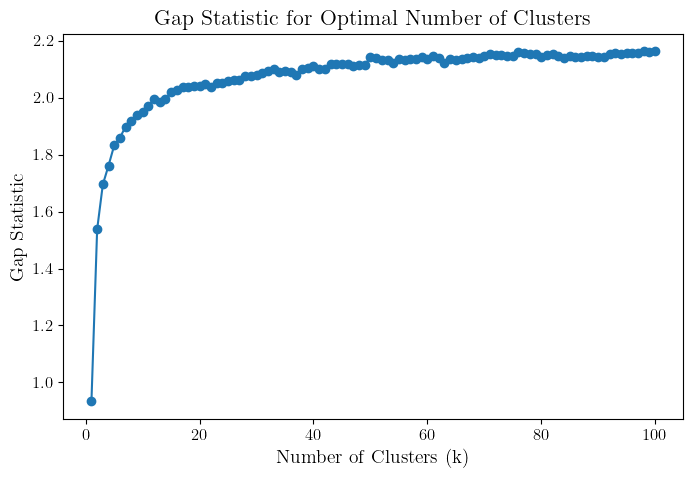

Optimal number of clusters: 98


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


def calculate_dispersion(data, labels):
    """
    Compute the total within-cluster dispersion for given data and cluster labels.
    """
    n_clusters = np.unique(labels).shape[0]
    dispersion = 0
    for k in range(n_clusters):
        cluster_points = data[labels == k]
        if cluster_points.size > 0:
            center = np.mean(cluster_points, axis=0)
            dispersion += np.sum(np.square(cluster_points - center))
    return dispersion

def gap_statistic(data, n_refs=10, max_clusters=10):
    """
    Computes Gap Statistic to find the optimal number of clusters.
    
    Parameters:
    - data: Original dataset.
    - n_refs: Number of reference datasets to generate.
    - max_clusters: Maximum number of clusters to test.

    Returns:
    - gaps: Gap values for each cluster number.
    - optimal_k: Number of clusters with the largest gap.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)  # Standardizing data for better performance
    gaps = []
    dispersions = []
    
    for k in range(1, max_clusters + 1):
        # KMeans on real data
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        dispersion = calculate_dispersion(data_scaled, kmeans.labels_)
        dispersions.append(dispersion)
        
        # Reference datasets (uniformly sampled)
        reference_dispersion = []
        for _ in range(n_refs):
            reference_data = np.random.uniform(data_scaled.min(axis=0), data_scaled.max(axis=0), size=data_scaled.shape)
            kmeans_ref = KMeans(n_clusters=k, random_state=42)
            kmeans_ref.fit(reference_data)
            ref_dispersion = calculate_dispersion(reference_data, kmeans_ref.labels_)
            reference_dispersion.append(ref_dispersion)
        
        # Compute the gap for this k
        mean_ref_dispersion = np.mean(reference_dispersion)
        gap = np.log(mean_ref_dispersion) - np.log(dispersion)
        gaps.append(gap)

    # Plotting Gap values for each cluster
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), gaps, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic for Optimal Number of Clusters')
    plt.show()
    
    # Finding the optimal k
    optimal_k = gaps.index(max(gaps)) + 1  # Adding 1 because index starts at 0
    print(f"Optimal number of clusters: {optimal_k}")
    
    return gaps, optimal_k

# Simulate some data (replace with your real dataset)
np.random.seed(42)
skill_matrix = onet_data_pivot.pivot_table(index='OCC_CODE', columns='Element ID', values='IM', aggfunc='mean').fillna(0)
# Compute gap statistic and determine optimal number of clusters
gaps, optimal_k = gap_statistic(skill_matrix, n_refs=20, max_clusters=100)

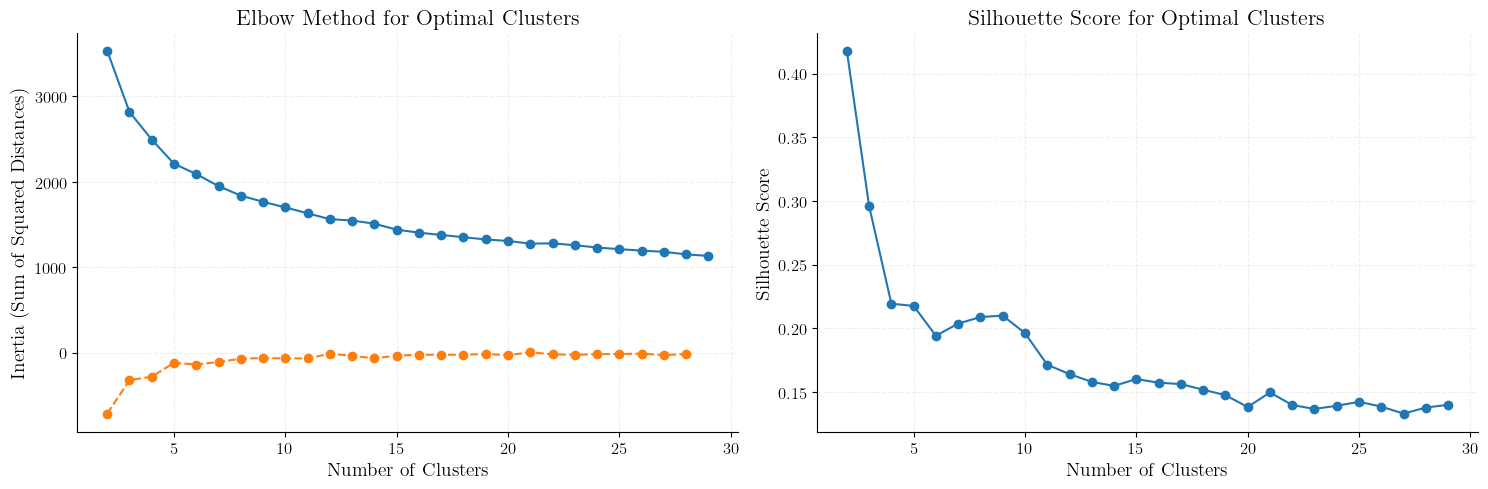

In [22]:
from sklearn.metrics import silhouette_score

# Pivot the data to prepare for clustering (using 'IM' for this example)
skill_matrix = onet_data_pivot.pivot_table(index='OCC_CODE', columns='Element ID', values='IM', aggfunc='mean').fillna(0)
# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(skill_matrix)
# Elbow Method and Silhouette Method to determine optimal number of clusters
distortions = []
silhouette_scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(standardized_data)
    score = silhouette_score(standardized_data, labels)
    silhouette_scores.append(score)
    distortions.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
[sns.despine(ax=a) for a in ax]
ax[0].plot(range(2, 30), distortions, marker='o', linestyle='-')
# Compute the "speed" of the change in inertia
speed = np.diff(distortions)
# Plot the speed of the change
ax[0].plot(range(2, 29), speed, marker='o', linestyle='--')
# Title and labels
ax[0].set_xlabel('Number of Clusters', fontsize=14)
ax[0].set_ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
ax[0].set_title('Elbow Method for Optimal Clusters', fontsize=16)
# Enhance gridlines and make axis labels more readable
ax[0].grid(True, linestyle='--', alpha=0.2)
sns.despine(ax=ax[0])

ax[1].plot(range(2, 30), silhouette_scores, marker='o', linestyle='-')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score for Optimal Clusters')
# Enhance gridlines and make axis labels more readable
ax[1].grid(True, linestyle='--', alpha=0.2)
sns.despine(ax=ax[1])

plt.tight_layout()
plt.show()


### Creating a Skill Index for Occupations Using PCA

In this analysis, we construct a **skill index** for occupations using Principal Component Analysis (PCA) on O*NET skill ratings. The process focuses on "Basic Skills" (Element ID starting with '2.A') and uses the **importance** scale for each skill.

#### Step-by-Step Explanation

1. **Data Selection and Filtering**:  
   We filter the dataset to include only rows where `Element ID` corresponds to "Basic Skills" (starting with '2.A'). Additionally, we focus on data where `Scale ID` is 'IM', representing the importance of each skill.

2. **Pivoting the Data**:  
   A pivot table is created where rows represent unique occupations (`O*NET-SOC Code`), columns represent individual skills (`Element ID`), and values are the importance ratings (`Data Value`). Missing values are replaced with zeros.

3. **Standardization**:  
   Since PCA is sensitive to scale, we standardize the data to have a mean of 0 and a standard deviation of 1 using `StandardScaler`.

4. **Principal Component Analysis (PCA)**:  
   We apply PCA with `n_components=1` to extract the first principal component, which explains the largest variance in the skill matrix. This component represents a summary measure of skill requirements.

5. **Constructing the Skill Index**:  
   The first principal component is added as a new column (`Skill Index`) in the skill matrix, providing a single metric that captures the underlying skill structure for each occupation.

#### Why Use PCA for Skill Index Construction?

- **Dimensionality Reduction**: Reduces the complexity of multiple skill variables into a single index.
- **Variance Explanation**: The first principal component captures the most significant patterns of variation across occupations.
- **Data-Driven Weights**: PCA provides an empirically derived weighting scheme for different skills based on their correlations.

This approach offers a robust method to quantify the overall skill intensity of occupations using standardized skill importance ratings.


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Filter for the "importance" or "level" data as required
importance_data = onet_data[onet_data['Scale ID'] == 'TOTAL'].drop(columns='Scale ID')
importance_data.rename(columns={'Data Value': 'TOTAL', 'Element ID': 'SKILL_ID'}, inplace=True)


def calculate_skill_index(importance_data, occ_code_title_dict, skill_dict, n_components=1):
    """
    Calculate the skill index for occupations using PCA on the importance data.

    Parameters:
    - importance_data: DataFrame containing the importance data for skills.
    - occ_code_title_dict: Dictionary mapping occupation codes to titles.
    - skill_dict: Dictionary mapping skill IDs to skill names.
    - n_components: Number of principal components to use for PCA.

    Returns:
    - skill_matrix: DataFrame containing the skill index for each occupation.
    """
    # Pivot the data to create a skill matrix: rows = occupations, columns = skills
    
    skill_matrix = importance_data.pivot_table(
        index='OCC_CODE',
        columns='SKILL_ID', 
        values='TOTAL', 
        aggfunc='mean'  # Handles any duplicates
    ).fillna(0)  # Replace missing values with 0

    # Standardize the data (mean=0, std=1)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(skill_matrix)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(standardized_data)


    # Check the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)

    # Extract and interpret loadings (weights) for each skill in the first component
    loadings = pca.components_[0]  # First component weights
    skills = skill_matrix.columns 
    skill_weights = pd.DataFrame({'Skill': skills, 'Weight': loadings})

    # Sort skills by their absolute weight to show the most important contributors
    skill_weights['AbsWeight'] = skill_weights['Weight'].abs()
    skill_weights_sorted = skill_weights.sort_values(by='AbsWeight', ascending=False)
    print("\nSkill Loadings for the First Principal Component:")
    display(skill_weights_sorted[['Skill', 'Weight']])

    # Construct Skill index using the weights of the first principal component
    skill_index = pd.Series(np.dot(standardized_data, loadings), index=skill_matrix.index)
    # Add the skill index to the Skill Matrix 
    skill_matrix['SKILL'] = skill_index

    # Reset the index to make it easier to work with
    skill_matrix = skill_matrix.reset_index()

    # Normalize the skill index to a 0-100 scale
    # skill_matrix['SKILL'] = (skill_matrix['SKILL'] - skill_matrix['SKILL'].min()) / (skill_matrix['SKILL'].max() - skill_matrix['SKILL'].min())

    # Sort the occupations by their skill index
    skill_matrix = skill_matrix.sort_values(by='SKILL', ascending=False)

    # Add the rank of each occupation based on the skill index
    skill_matrix['RANK'] = np.arange(1, len(skill_matrix) + 1)

    # Add occupation titles to the skill matrix
    skill_matrix['OCC_TITLE'] = skill_matrix.loc[:, 'OCC_CODE'].map(occ_code_title_dict)

    skill_matrix.rename(columns=skill_dict, inplace=True)

    return skill_matrix

# Calculate the skill index
skill_matrix_detailed = calculate_skill_index(importance_data, occ_code_title_dict, skill_dict)


# Display the skill index for the top 10 occupations
print("\nSkill Index for the Top 10 Occupations:")
display(skill_matrix_detailed.head(10))

# Display the skill index for the bottom 10 occupations
print("\nSkill Index for the Bottom 10 Occupations:")
display(skill_matrix_detailed.tail(10))

Explained Variance Ratio: [0.76122719]

Skill Loadings for the First Principal Component:


,Skill,Weight
7,2.A.2.b,0.348208
0,2.A.1.a,0.347375
6,2.A.2.a,0.343882
2,2.A.1.c,0.342123
3,2.A.1.d,0.335920
1,2.A.1.b,0.331348
8,2.A.2.c,0.311404
9,2.A.2.d,0.298930
5,2.A.1.f,0.245184
4,2.A.1.e,0.231730



Skill Index for the Top 10 Occupations:


SKILL_ID,OCC_CODE,Reading Comprehension,Active Listening,Writing,Speaking,Mathematics,Science,Critical Thinking,Active Learning,Learning Strategies,Monitoring,SKILL,RANK,OCC_TITLE
119,19-2012,24.9900,19.0000,20.0000,19.5700,23.3750,26.5650,20.1056,22.0000,19.4000,13.0000,7.713339,1,Physicists
111,19-1021,22.9950,18.0456,21.7600,19.0344,18.4300,24.3200,21.7600,21.6300,17.5200,16.4900,7.478117,2,Biochemists and Biophysicists
116,19-1041,21.7600,19.5700,19.0344,19.5700,15.4500,20.6000,19.6350,19.0000,13.5800,15.3850,6.160427,3,Epidemiologists
181,25-1054,20.6000,18.4800,20.0000,20.6000,14.4800,19.0344,19.5200,17.5200,17.5200,14.4800,6.079624,4,"Physics Teachers, Postsecondary"
118,19-2011,21.7600,16.4800,20.6000,19.0000,20.6000,21.7600,16.9744,19.5200,15.0000,12.2356,5.934645,5,Astronomers
117,19-1042,21.0000,17.0000,20.7400,18.0456,14.9144,20.6000,19.0000,20.6000,13.1144,14.9144,5.853548,6,"Medical Scientists, Except Epidemiologists"
167,23-1023,20.1875,29.4000,20.1056,20.1056,4.4944,2.4150,28.0600,18.4800,7.9200,15.9856,5.795142,7,"Judges, Magistrate Judges, and Magistrates"
128,19-3032,20.8050,20.2356,20.7400,19.0344,13.5800,14.5500,18.5400,15.9856,14.4800,16.4900,5.632843,8,Industrial-Organizational Psychologists
178,25-1051,20.4800,18.4800,19.0000,22.5625,13.5200,16.4800,17.0000,16.4900,16.4900,14.9144,5.612272,9,"Atmospheric, Earth, Marine, and Space Sciences..."
288,29-1217,22.6600,19.1250,17.5200,18.0456,9.3600,15.4500,20.1056,17.3250,14.3650,18.4800,5.597776,10,Neurologists



Skill Index for the Bottom 10 Occupations:


SKILL_ID,OCC_CODE,Reading Comprehension,Active Listening,Writing,Speaking,Mathematics,Science,Critical Thinking,Active Learning,Learning Strategies,Monitoring,SKILL,RANK,OCC_TITLE
373,37-2012,5.5544,5.8300,4.2400,5.8300,1.8800,0.0000,5.8300,3.4344,3.1800,5.5000,-4.596670,728,Maids and Housekeeping Cleaners
735,53-7081,5.2400,7.2000,5.0000,5.7600,0.0000,0.0000,7.2050,3.6450,0.5244,5.0000,-4.678399,729,Refuse and Recyclable Material Collectors
368,35-9021,4.2400,6.1875,3.5000,5.8300,2.0000,0.0000,5.5544,4.0000,2.5000,5.5544,-4.731635,730,Dishwashers
375,37-3011,4.2300,6.1875,2.1875,5.4144,1.3125,1.4256,5.4144,4.5000,3.9856,4.7000,-4.768572,731,Landscaping and Groundskeeping Workers
730,53-7064,5.2400,5.5000,3.7600,5.2400,2.5000,0.0000,5.5000,2.1200,2.2400,6.3600,-4.826166,732,"Packers and Packagers, Hand"
479,45-2041,3.6450,6.1875,3.1050,6.1875,1.4256,0.3125,5.6250,3.1800,1.4256,6.1056,-4.888871,733,"Graders and Sorters, Agricultural Products"
420,41-9012,5.0000,7.2050,4.0000,5.8300,0.3125,0.0000,4.9256,3.0456,0.1344,3.2900,-5.203367,734,Models
727,53-7061,4.2300,5.0000,2.1056,4.9256,1.2150,0.3125,4.5000,3.0000,1.8800,6.1875,-5.209218,735,Cleaners of Vehicles and Equipment
607,51-3023,3.2900,5.8950,1.7500,5.1700,1.3125,0.0000,4.4744,3.0000,2.5000,4.2300,-5.362532,736,Slaughterers and Meat Packers
638,51-6021,3.5000,4.0000,2.6250,4.2400,1.2150,0.0000,5.6250,3.1800,1.7500,5.0456,-5.383071,737,"Pressers, Textile, Garment, and Related Materials"


/var/folders/59/h6mpwd8s71n4m11hd0jkp45h0000gn/T/ipykernel_77541/1214889615.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_matrix['SKILL'], shade=True, color="b")


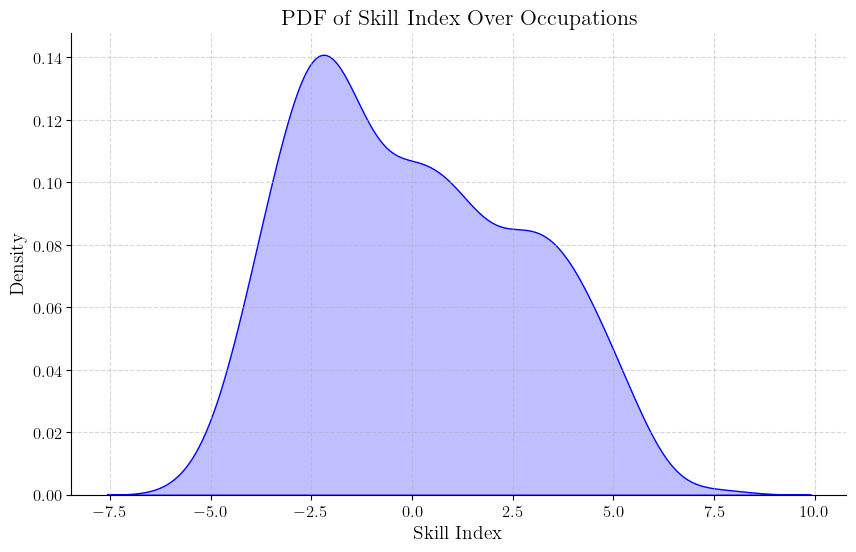

In [190]:
# Plot the PDF of the skill index over occupations
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(skill_matrix['SKILL'], shade=True, color="b")
plt.title('PDF of Skill Index Over Occupations')
plt.xlabel('Skill Index')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine(ax=ax)
plt.show()

Construct Skill index for major occupational groups

In [9]:
# Using the BLS data we can create groups of occupations

major_occ_codes = bls_data[(bls_data.AREA == 0) & (bls_data.O_GROUP == 'major')].OCC_CODE

# Use the first two digits of the occupation code to group occupations to create a 'Major Group'

dict_major_group = {}
for occ_code in major_occ_codes:
    detailed_occ_codes = bls_data[(bls_data.AREA == 0) & (bls_data.O_GROUP == 'detailed') & (bls_data.OCC_CODE.str.startswith(occ_code[:2]))].OCC_CODE.to_list()
    dict_major_group[occ_code] = detailed_occ_codes

importance_data_major = pd.DataFrame()
for key in dict_major_group.keys():
    shares_emp_detail = bls_data[(bls_data.AREA == 0) & 
                                    (bls_data.OCC_CODE.isin(dict_major_group[key]))
                                ].set_index("OCC_CODE").TOT_EMP.transform(lambda x: x/x.sum()).rename("SHARE_EMP")

    weighted_importance = importance_data.set_index('OCC_CODE').merge(
            shares_emp_detail, left_index=True, right_index=True).groupby('SKILL_ID').apply(
                lambda x: (x['TOTAL'] * x['SHARE_EMP']).sum(), include_groups=False)

    weighted_importance = weighted_importance.reset_index(name='TOTAL')
    weighted_importance['OCC_CODE'] = key

    importance_data_major = pd.concat([importance_data_major, weighted_importance], ignore_index=True)

# Re-arrange the columns to match the original importance_data
importance_data_major = importance_data_major[['OCC_CODE', 'SKILL_ID', 'TOTAL']]

In [10]:
# Create the skill index for major groups

skill_matrix_major = calculate_skill_index(importance_data_major, occ_code_title_dict, skill_dict)

# Remove the word 'occupations' from the occupation title
skill_matrix_major['OCC_TITLE'] = skill_matrix_major['OCC_TITLE'].str.replace('Occupations', '')

print("\nSkill Index for the Top 10 Major Groups:")
display(skill_matrix_major)

Explained Variance Ratio: [0.78530641]

Skill Loadings for the First Principal Component:


,Skill,Weight
7,2.A.2.b,0.353430
0,2.A.1.a,0.348827
6,2.A.2.a,0.346946
2,2.A.1.c,0.342249
3,2.A.1.d,0.339427
1,2.A.1.b,0.336176
9,2.A.2.d,0.326032
8,2.A.2.c,0.302638
4,2.A.1.e,0.227119
5,2.A.1.f,0.195465



Skill Index for the Top 10 Major Groups:


SKILL_ID,OCC_CODE,Reading Comprehension,Active Listening,Writing,Speaking,Mathematics,Science,Critical Thinking,Active Learning,Learning Strategies,Monitoring,SKILL,RANK,OCC_TITLE
6,23-0000,19.161967,19.561942,18.269612,19.070191,3.928672,0.719750,18.411230,13.039039,7.868751,11.136055,4.987303,1,Legal
4,19-0000,15.957516,14.106234,14.383612,13.626721,9.805366,11.613902,14.270183,12.549015,9.454513,11.607201,4.231450,2,"Life, Physical, and Social Science"
0,11-0000,15.051321,15.179774,13.129380,15.047306,8.262210,1.710136,14.545844,12.817527,10.084943,14.971727,4.105162,3,Management
3,17-0000,15.801567,13.697485,12.682778,12.941250,12.799283,9.067744,14.473520,12.081188,8.270862,11.571787,3.850542,4,Architecture and Engineering
9,29-0000,13.839216,14.001456,11.323268,13.309568,6.832983,7.148437,13.179427,11.183454,9.232132,12.192238,2.895699,5,Healthcare Practitioners and Technical
8,27-0000,13.954236,14.213942,12.858229,14.168256,4.090284,0.659168,13.455533,10.859894,8.802011,11.423432,2.309656,6,"Arts, Design, Entertainment, Sports, and Media"
5,21-0000,12.142490,14.009842,11.427315,12.988682,3.063699,2.665713,11.793774,9.726947,8.439652,10.716877,1.431272,7,Community and Social Service
7,25-0000,11.424134,11.240900,10.414525,11.723054,5.229001,2.364541,10.394027,9.833783,12.184145,10.563043,1.377103,8,Educational Instruction and Library
11,33-0000,10.521894,11.990299,8.642578,11.503748,3.653736,1.135143,11.395034,9.350030,7.090604,11.242991,0.416495,9,Protective Service
16,43-0000,12.060658,13.285550,9.985279,12.339652,5.621140,0.054770,10.526973,7.957407,5.914110,9.360979,0.324272,10,Office and Administrative Support


## 2.3 Clean and Merge Data
We clean the data by handling missing values and ensuring consistent formatting (e.g., ensuring occupation codes are of the correct type). We then merge the O*NET and BLS data based on the occupation code to combine the automation risk score with employment and wage information.

In [11]:
# Clean O*NET Data (Ensure correct formatting and fill missing values)
skill_matrix = pd.concat([skill_matrix_detailed, skill_matrix_major], ignore_index=True)
skill_matrix = skill_matrix.dropna(subset=['SKILL'])
skill_matrix['OCC_CODE'] = skill_matrix['OCC_CODE'].astype(str)

# Clean BLS Data (Remove missing values for employment and wage columns)
bls_data = bls_data.dropna(subset=["TOT_EMP", "H_MEAN", "A_MEAN"])
bls_data['OCC_CODE'] = bls_data['OCC_CODE'].astype(str)

# Merge O*NET and BLS Data
merged_data = pd.merge(bls_data, skill_matrix[['OCC_CODE', 'SKILL']], on='OCC_CODE', how='inner')

### Log Mean Wage vs. Skill Index for Detailed Occupations

This plot illustrates the relationship between the skill index of detailed occupations and the log-transformed mean annual wage across U.S. metropolitan areas. The skill index is based on the occupational skill requirements as defined in the O*NET dataset, reflecting the complexity and level of expertise required for each occupation. The y-axis represents the log of the mean annual wage for each occupation, providing a more normalized view of wage distribution and mitigating the effect of extreme wage values.

Each point on the scatter plot represents a detailed occupation, with the size of the point corresponding to the total employment in that occupation, scaled for visualization clarity. Larger points indicate occupations with higher employment, while smaller points represent those with lower employment levels. The regression line (blue) reflects the overall trend between skill level and wage, helping to identify the general relationship: whether higher skill levels tend to be associated with higher wages across different occupations.

Additionally, we include a legend that categorizes occupations by total employment, highlighting key percentiles in employment size. This visualization allows for an understanding of how the concentration of skilled labor in different sectors relates to wage growth, while also providing insights into the potential economic mobility within skill categories.

This analysis is crucial for understanding the spatial and occupational patterns of wage inequality and skill distribution across the U.S., and can inform policies related to education, workforce development, and regional economic planning.


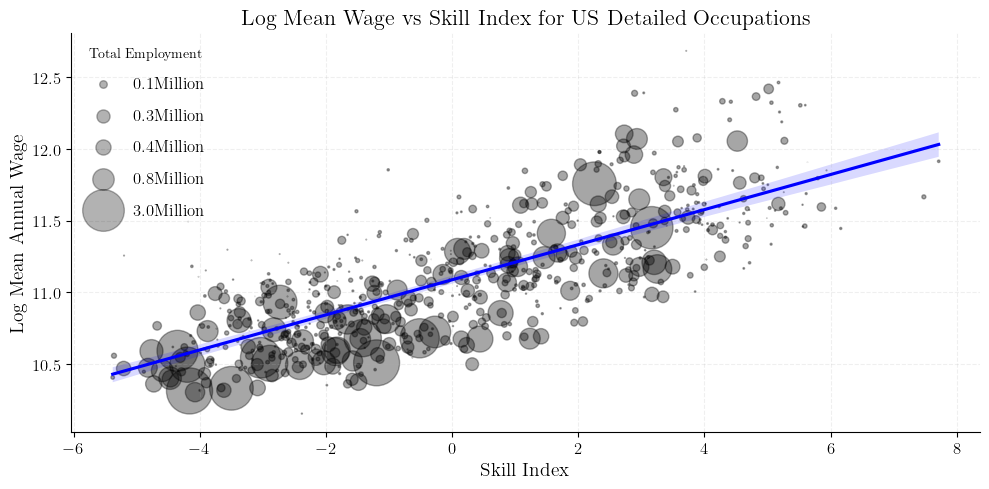

In [159]:
us_skill_wage_data = merged_data[(merged_data['AREA'] == 0) & (merged_data['A_MEAN'] > 0)].copy()
# reverse the dict_major_group dictionary to get a mapping from detailed occupation to major occupation
dict_detailed_major = {detailed_occ: major_occ for major_occ, detailed_occs in dict_major_group.items() for detailed_occ in detailed_occs}
# Add which occupation major group each detailed occupation belongs to
us_skill_wage_data.loc[:, "OCC_CODE_MAJOR_PARENT"] = us_skill_wage_data.apply(lambda x: dict_detailed_major[x['OCC_CODE']] if x['O_GROUP'] == 'detailed' else x['OCC_CODE'], axis=1)
us_skill_wage_data.loc[:, "OCC_TITLE_MAJOR_PARENT"] = us_skill_wage_data['OCC_CODE_MAJOR_PARENT'].map(occ_code_title_dict)
# Remove the word 'occupations' from the occupation title
us_skill_wage_data.loc[:, "OCC_TITLE_MAJOR_PARENT"] = us_skill_wage_data['OCC_TITLE_MAJOR_PARENT'].str.replace('Occupations', '')
# Compute log of the mean annual wage
us_skill_wage_data.loc[:, 'LOG_A_MEAN'] = [np.log(x) for x in us_skill_wage_data["A_MEAN"]]
# Compute log of the total employment
us_skill_wage_data.loc[:, 'LOG_TOT_EMP'] = [np.log(x) for x in us_skill_wage_data["TOT_EMP"]]
us_skill_wage_data

# Create a scatter plot of mean wage vs skill index with ordered categories
fig, ax = plt.subplots(figsize=(10,5)) 

# Ensure the size of 's' matches the size of the data points
s_values = 3 * us_skill_wage_data[us_skill_wage_data.O_GROUP == 'detailed']['TOT_EMP'].astype(float) / 10e3

my_kws={'alpha':0.35,
    'color':'black',
    's': s_values
    }

scatter = sns.regplot(x='SKILL',
            y='LOG_A_MEAN',
            data=us_skill_wage_data[us_skill_wage_data.O_GROUP == 'detailed'],                                
            ax=ax,                                   
            scatter_kws=my_kws,                      
            color='blue',           
            ci=99)

# Add legend for size
percentiles = [75, 85, 90, 95, 99]
example_sizes = us_skill_wage_data[us_skill_wage_data.O_GROUP == 'detailed'].TOT_EMP.astype(float).quantile(
    [p / 100 for p in percentiles])
example_sizes = [int(10**np.floor(np.log10(x)) * (x / 10**np.floor(np.log10(x))).round(0)) for x in example_sizes]
for size in example_sizes:
    plt.scatter([], [], c='k', alpha=0.3, s=3 * size / 10e3, label=f'{size / 1e6:.1f}Million')

ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Total Employment', loc='upper left')

sns.despine(ax=ax)

# Enhance gridlines and make axis labels more readable
ax.grid(True, linestyle='--', alpha=0.2)
sns.despine(ax=ax)

# Title and labels
plt.title('Log Mean Wage vs Skill Index for US Detailed Occupations', fontsize=16)
plt.xlabel('Skill Index', fontsize=14)
plt.ylabel('Log Mean Annual Wage', fontsize=14)
plt.tight_layout()
plt.show()


# Step 3: Regional Skill Composition and Wage Growth

This section examines the regional distribution of skill levels across occupations and its relationship with wage growth and economic mobility. We will calculate a regional skill concentration score and explore how it correlates with wage growth and upward mobility across U.S. metropolitan areas.

## 3.1 Calculate Regional Skill Concentration Score
The function `calculate_regional_skill_concentration` computes a regional skill concentration score by weighting the skill index of each occupation by its relative employment share in the region. This score captures the extent to which regions are specialized in high-skill versus low-skill occupations.

- For each region:
  - Weight skill index by occupation share in regional employment:

$$
\text { Regional Skill Concentration }_r=\sum_i\left(\operatorname{Skill}_i \times \frac{\text { Employment }_{i, r}}{\sum_i \text { Employment }_{i, r}}\right)
$$

This score will help us understand how skill concentration in different regions impacts wage growth and economic mobility. A higher skill concentration in a region may correlate with higher wages and better upward mobility, while regions with lower skill concentrations might experience slower wage growth or limited mobility opportunities.


In [161]:
def calculate_regional_skill_concentration(data, region_col, skill_col, emp_col, o_level = 'detailed'):
    """
    Function to calculate the regional skill concentration score based on occupation employment and skill index.
    """

    # Filter data to the occupation level of interest
    sub_data = data[data['O_GROUP'] == o_level]

    regional_skill_concentration = sub_data.groupby(region_col).apply(
        lambda x: np.sum(x[skill_col] * (x[emp_col] / x[emp_col].sum()))
    ).reset_index(name='regional_skill_concentration')
    
    return regional_skill_concentration

# Apply function to calculate regional skill concentration scores
regional_skill_data = calculate_regional_skill_concentration(merged_data,
                                                            region_col='AREA', 
                                                            skill_col='SKILL', 
                                                            emp_col='TOT_EMP')

regional_skill_data.sort_values(by='regional_skill_concentration', ascending=False)


/var/folders/59/h6mpwd8s71n4m11hd0jkp45h0000gn/T/ipykernel_77541/4085916364.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_skill_concentration = sub_data.groupby(region_col).apply(


,AREA,regional_skill_concentration
50,15680,0.321443
543,25,-0.020340
43,14500,-0.061301
378,71650,-0.064225
341,45940,-0.098447
...,...,...
531,7200006,-1.562263
297,41500,-1.594226
249,36140,-1.635129
212,31460,-1.656302


In [188]:
sub = merged_data[(merged_data.AREA == 15680) & (merged_data.O_GROUP == 'detailed')].copy()
sub.loc[:, "SHARE_EMP"] = sub.TOT_EMP / sub.TOT_EMP.sum()
(sub.SKILL * sub.SHARE_EMP).sum()

0.3214429307912814